In [1]:
import torch
import pandas as pd
import os
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors
from torchvision import transforms

In [2]:
import sys
sys.path.append("/home/lchanch/model_training")
import early_stopping

In [3]:
import sys
sys.path.append("/home/lchanch")
import networks

In [4]:
import sys
sys.path.append("/home/lchanch/model_training")
from LRP import ISNetFlexTorch
from LRP import LRPDenseNetZe

In [ ]:
#==========Create DenseNet and Load Weights===========

In [5]:
def load_densenet_lrp_weights(
    model,
    checkpoint_state_dict,
    *,
    strict=False,
    verbose=True
):
    """
    Loads DenseNet weights into an LRP-compatible DenseNet.
    Supports:
        - ERM checkpoints
        - ISNetDANN checkpoints
    Ignores adversarial / explanation-specific modules.
    """

    clean_state_dict = {}

    # ---- Detectar tipo de checkpoint ----
    is_isnet = any(
        k.startswith("isnet_network.network.model.")
        for k in checkpoint_state_dict.keys()
    )

    is_erm = any(
        k.startswith("featurizer.network.")
        for k in checkpoint_state_dict.keys()
    )

    if not (is_isnet or is_erm):
        raise ValueError("Checkpoint no reconocido (ni ERM ni ISNetDANN)")

    if verbose:
        print(
            "🔹 Detectado checkpoint",
            "ISNetDANN" if is_isnet else "ERM"
        )

    # ---- ERM ----
    if is_erm:
        for k, v in checkpoint_state_dict.items():

            # Backbone
            if k.startswith("featurizer.network.features."):
                new_k = k.replace(
                    "featurizer.network.features.",
                    "features."
                )
                clean_state_dict[new_k] = v

            # Classifier
            elif k.startswith("classifier."):
                clean_state_dict[k] = v

    # ---- ISNetDANN ----
    elif is_isnet:
        for k, v in checkpoint_state_dict.items():

            # Backbone
            if k.startswith("isnet_network.network.model.features."):
                new_k = k.replace(
                    "isnet_network.network.model.features.",
                    "features."
                )
                clean_state_dict[new_k] = v

            # Classifier
            elif k.startswith(
                "isnet_network.network.model.classifier."
            ):
                new_k = k.replace(
                    "isnet_network.network.model.",
                    ""
                )
                clean_state_dict[new_k] = v

    # ---- Cargar pesos ----
    missing, unexpected = model.load_state_dict(
        clean_state_dict,
        strict=strict
    )

    if verbose:
        print("✅ Pesos cargados en DenseNet LRP")
        print("Missing keys:", missing)
        print("Unexpected keys:", unexpected)

    return model


In [6]:
densenet_lrp_erm = LRPDenseNetZe.densenet121(pretrained=False, num_classes=2)
densenet_lrp_isnet = LRPDenseNetZe.densenet121(pretrained=False, num_classes=2) 

In [7]:
#best models (baseline and mitigation) for the setting No Finding-Sex
model_path_erm="/home/lchanch/initial_training/output_sweep_12/grid_sex_mimic_12/8567bca8c4876916928b7465a52cdeae"
model_path_isnet="/home/lchanch/model_training/ISNetDANN/train/grid_sex_ISNetDANN/e71e3c622a942657993e10cf0b5e652b"

In [8]:
#Load weights
checkpoint_ERM = torch.load(os.path.join(model_path_erm, "model.best.pkl"))
state_dict_ERM = checkpoint_ERM['model_dict']
densenet_w_ERM = load_densenet_lrp_weights(densenet_lrp_erm, state_dict_ERM, strict=True)

checkpoint_ISNetDANN = torch.load(os.path.join(model_path_isnet, "model.best.pkl"))
state_dict_ISNetDANN = checkpoint_ISNetDANN['model_dict']
densenet_w_ISNetDANN = load_densenet_lrp_weights(densenet_lrp_isnet, state_dict_ISNetDANN, strict=True)

/tmp/ipykernel_1397537/4115355979.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_ERM = torch.load(os.path.join(model_path_erm, "model.best.pkl"))


🔹 Detectado checkpoint ERM
✅ Pesos cargados en DenseNet LRP
Missing keys: []
Unexpected keys: []
🔹 Detectado checkpoint ISNetDANN
✅ Pesos cargados en DenseNet LRP
Missing keys: []
Unexpected keys: []


/tmp/ipykernel_1397537/4115355979.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_ISNetDANN = torch.load(os.path.join(model_path_isnet, "model.best.pkl"))


In [ ]:
#==========Create DenseNet and Load Weights===========

In [ ]:
#===============preprocess image and masks===================

In [9]:
#prcess masks
def rle_decode(rle_str, shape):
    s = list(map(int, rle_str.split()))
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def expand_downward_smooth(mask, max_shift=100, step=20):
    h, w = mask.shape
    expanded = np.zeros_like(mask, dtype=np.float32)

    for shift in range(0, max_shift + 1, step):
        shifted = np.roll(mask, shift, axis=0).astype(np.float32)
        shifted[:shift, :] = 0
        decay = 1.0 - (shift / max_shift)
        expanded += shifted * decay

    expanded = np.clip(expanded, 0, 1)
    expanded_blur = cv2.GaussianBlur(expanded, (21, 21), sigmaX=15, sigmaY=15)

    return (expanded_blur > 0.05).astype(np.uint8)

In [10]:
def transform_image_and_rle_mask_rgb(
    image_path,
    rle_LL,
    rle_RL,
    rle_H,
    om_height,
    om_width,
    size=256
):
   
    image = Image.open(image_path).convert("RGB")

    mask_LL = rle_decode(rle_LL, (om_height, om_width))
    mask_RL = rle_decode(rle_RL, (om_height, om_width))
    mask_H  = rle_decode(rle_H,  (om_height, om_width))

    combined_mask = np.clip(
        mask_LL + mask_RL + mask_H, 0, 1
    ).astype(np.uint8)

 
    kernel_general = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (15, 30)
    )
    dilated_general = cv2.dilate(
        combined_mask, kernel_general, iterations=1
    )

    expanded_left  = expand_downward_smooth(mask_LL)
    expanded_right = expand_downward_smooth(mask_RL)

    final_mask = np.clip(
        dilated_general + expanded_left + expanded_right,
        0, 1
    ).astype(np.uint8)

    mask_img = Image.fromarray(final_mask * 255).convert("L")

    mask_img = mask_img.resize(image.size, resample=Image.NEAREST)

    image = TF.resize(image, size, interpolation=TF.InterpolationMode.BILINEAR)
    mask  = TF.resize(mask_img, size, interpolation=TF.InterpolationMode.NEAREST)

    image = TF.center_crop(image, size)
    mask  = TF.center_crop(mask,  size)

    image_crop_pil = image.copy()

    # Imagen -> tensor + normalize
    image = TF.to_tensor(image)
    image = TF.normalize(
        image,
        mean=[0.5307, 0.5307, 0.5307],
        std=[0.2583, 0.2583, 0.2583]
    )

    # Mask -> tensor binario
    mask = TF.to_tensor(mask)
    mask = (mask > 0.5).float()

    # Batch dimension
    image = image.unsqueeze(0).float()  # [1, 3, 256, 256]
    mask  = mask.unsqueeze(0).float()   # [1, 1, 256, 256]

    return image, mask, image_crop_pil

In [ ]:
#===============preprocess image and masks===================

In [ ]:
#===================CXR subset=================

In [ ]:
#stratified subset of test images -> 100 CXR

In [11]:
df_image_mask = pd.read_csv("/home/lchanch/df_construction_mapping/image_mask_df")
df_image_mask.head(1)

dicom_id  subject_id  study_id  \
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   

                                        reduced_path  \
0  p10/p10000032/s50414267/02aa804e-bde0afdd-112c...   

                                                path ViewPosition  No Finding  \
0  /home/lchanch/initial_image_prepro/downsample_...           PA         1.0   

   Pleural Effusion  Cardiomegaly  Pneumothorax  sex  race  sex_race  age  \
0               0.0           0.0           0.0    0     0         1    2   

   split                                          Left Lung  \
0      0  792824 6 795358 20 797892 34 800426 48 802960 ...   

                                          Right Lung  \
0  812519 6 815054 18 817588 30 820123 42 822658 ...   

                                               Heart  Width  Height  
0  3015910 10 3018442 28 3020973 47 3023504 66 30...   2544    3056

In [12]:
df_test = df_image_mask[df_image_mask['split'] == 2]
df_test.shape

(31080, 20)

In [13]:
df_test_reduced=df_test[['dicom_id', 'path', 'sex', 'No Finding', 'Left Lung', 'Right Lung', 'Heart', 'Width', 'Height']]
df_test_reduced.head(1)

dicom_id  \
21  1fe73f8e-036bd24e-4578c891-33c1746e-864884a7   

                                                 path  sex  No Finding  \
21  /home/lchanch/initial_image_prepro/downsample_...    0         0.0   

                                            Left Lung  \
21  1533224 9 1535754 27 1538284 45 1540813 64 154...   

                                           Right Lung  \
21  1410383 10 1412910 31 1415437 51 1417963 73 14...   

                                                Heart  Width  Height  
21  3336524 10 3339053 31 3341581 53 3344110 73 33...   2544    3056

In [14]:
#stratified random subset of 100 test images
np.random.seed(42)

N = 1000

df_nf1 = df_test_reduced[df_test_reduced['No Finding'] == 1]
df_nf0 = df_test_reduced[df_test_reduced['No Finding'] == 0]

p_nf1 = len(df_nf1) / len(df_test_reduced)
n_nf1 = int(round(N * p_nf1))
n_nf0 = N - n_nf1

idx_nf1 = np.random.choice(df_nf1.index, size=n_nf1, replace=False)
idx_nf0 = np.random.choice(df_nf0.index, size=n_nf0, replace=False)

idx = np.concatenate([idx_nf1, idx_nf0])
np.random.shuffle(idx)

df_test_sample = df_test_reduced.loc[idx]
df_test_sample.shape

(1000, 9)

In [15]:
print("Original:")
print(df_test_reduced['No Finding'].value_counts(normalize=True))

print("\nSample:")
print(df_test_sample['No Finding'].value_counts(normalize=True))


Original:
No Finding
0.0    0.674292
1.0    0.325708
Name: proportion, dtype: float64

Sample:
No Finding
0.0    0.674
1.0    0.326
Name: proportion, dtype: float64


In [23]:
df_10 = df_test_sample.sample(n=10, random_state=7)
df_10.shape

(10, 9)

In [ ]:
#===================CXR subset=================

In [ ]:
#=============LRP Flex implementation===========

In [16]:
def LRPFlex(df, densenet, ex_class=1, show=False, device="cuda"):
    
    net_lrp = ISNetFlexTorch.ISNetFlex(
        model=densenet,
        architecture='densenet121',
        selective=True,
        Zb=True,
        multiple=False,
        HiddenLayerPenalization=False,
        randomLogit=False,
        explainLabels=True
    ).to(device)
    
    net_lrp.eval()

    results = []
    
    for _, row in tqdm(df.iterrows(),
                       total=len(df),
                       desc="Computing BRR (LRP-Flex)"):
    
        res = LRPFlex_compute_BRR(
            df_row=row,
            net=net_lrp,
            ex_class=ex_class,
            show=show,   # SOLO True para debug
            device=device
        )
    
        results.append(res)
    
    df_brr = pd.DataFrame(results)
    
    return df_brr

In [17]:
def LRPFlex_compute_BRR(df_row, net, ex_class=1, show=False, device="cuda"):
    
    # ===== 1. Load image + lung mask =====
    img_tensor, mask_tensor, img_vis = transform_image_and_rle_mask_rgb(
        image_path=df_row['path'],
        rle_LL=df_row['Left Lung'],
        rle_RL=df_row['Right Lung'],
        rle_H=df_row['Heart'],
        om_height=df_row['Height'],
        om_width=df_row['Width']
    )

    img_tensor = img_tensor.to(device)
    mask_tensor = mask_tensor.to(device)


    # ===== 2. Forward + LRP =====
    out = net(img_tensor, runLRPFlex=True, labels=torch.tensor([ex_class], device=device))
    heatmap = out['LRPFlex']['input']  # [1, 1, 3, H, W] or similar

    # ===== 4. Process heatmap =====
    R = torch.abs(heatmap).mean(dim=2)  # average channels → [1, 1, H, W]

    total_relevance = R.sum().item()
    background_relevance = (R * (1 - mask_tensor)).sum().item()

    brr = background_relevance / (total_relevance + 1e-8)

    # ===== 5. Optional visualization =====
    if show:
    
        #h = R.squeeze().detach().cpu().numpy()
        h = heatmap.squeeze().mean(0).detach().cpu().numpy()
        norm = colors.TwoSlopeNorm(vmin=h.min(), vcenter=0, vmax=h.max())

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img_vis)
        axes[0].axis("off")
        axes[0].set_title("Original Image")

        im = axes[1].imshow(h, cmap='RdBu_r', norm=norm, interpolation='nearest')
        #axes[1].imshow(mask_tensor.squeeze().cpu(), cmap="Greens", alpha=0.25)
        axes[1].set_title(f"LRP heatmap\nBRR={brr:.3f}")

        plt.tight_layout()
        plt.show()

    return {
        "dicom_id": df_row["dicom_id"],
        "BRR": brr,
        "total_relevance": total_relevance
    }

In [ ]:
#------------ERM

In [ ]:
#visualization of 10 samples

Using custom model. Ensure that ReLU layers are not re-utilized inside the model and avoid in-place operations
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]


Computing BRR (LRP-Flex):   0%|          | 0/10 [00:00<?, ?it/s]

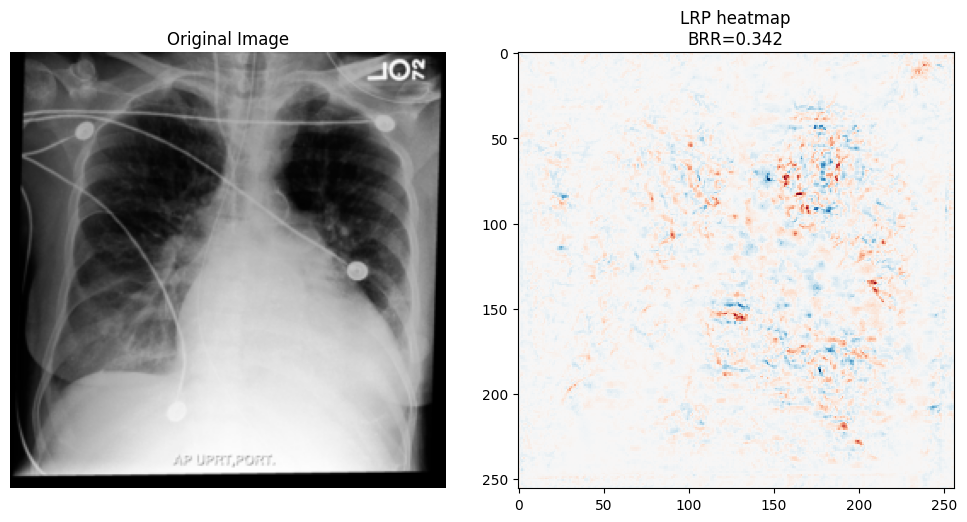

Computing BRR (LRP-Flex):  10%|█         | 1/10 [00:01<00:17,  1.96s/it]

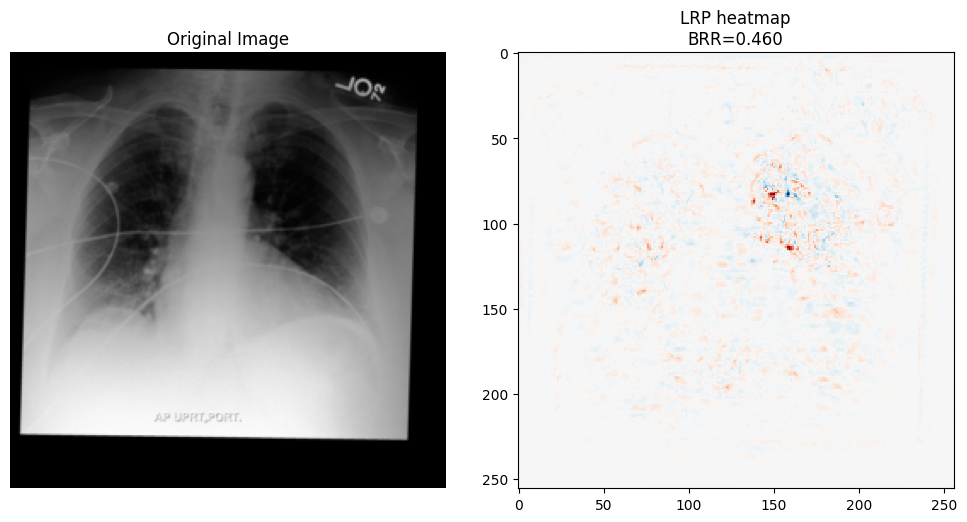

Computing BRR (LRP-Flex):  20%|██        | 2/10 [00:03<00:11,  1.44s/it]

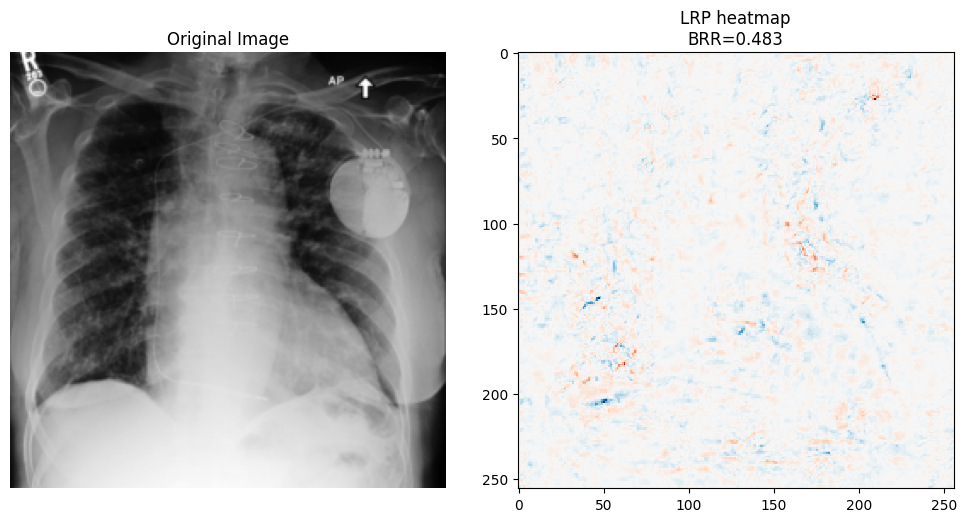

Computing BRR (LRP-Flex):  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

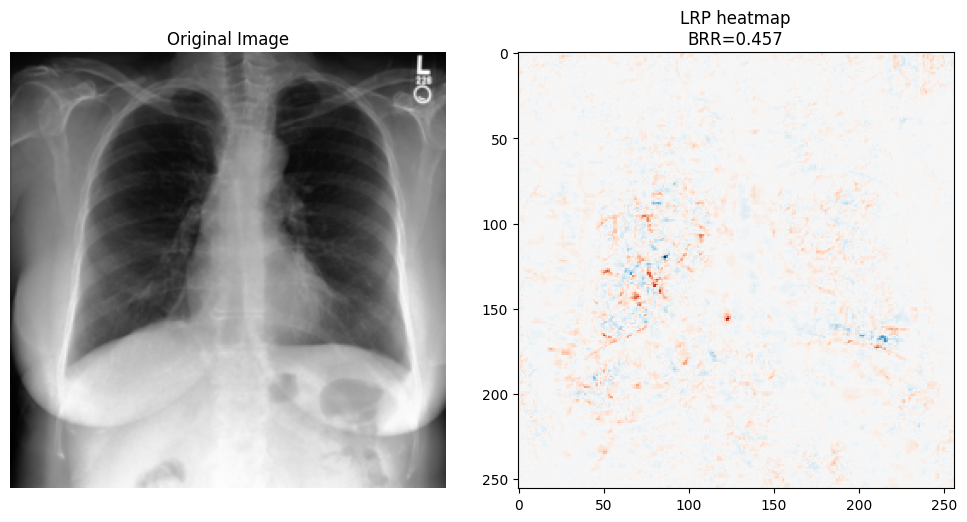

Computing BRR (LRP-Flex):  40%|████      | 4/10 [00:04<00:06,  1.03s/it]

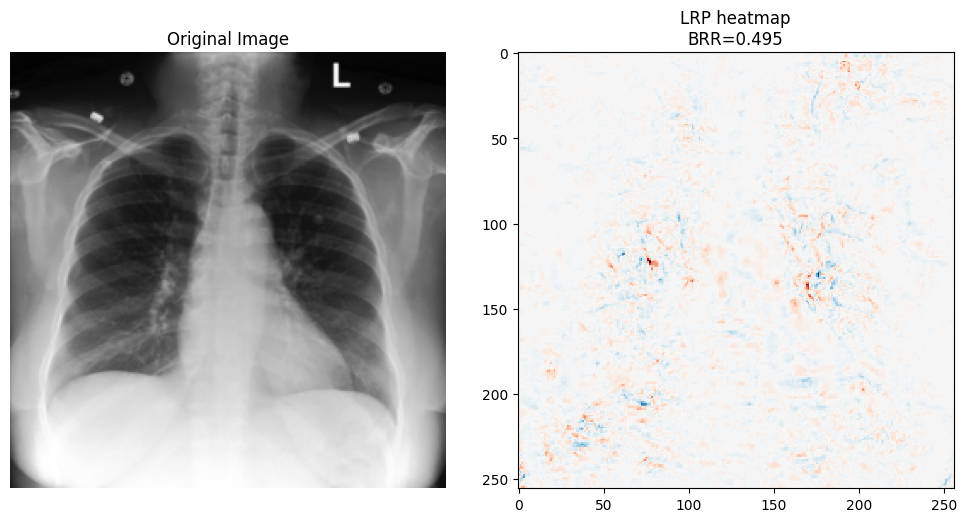

Computing BRR (LRP-Flex):  50%|█████     | 5/10 [00:05<00:04,  1.18it/s]

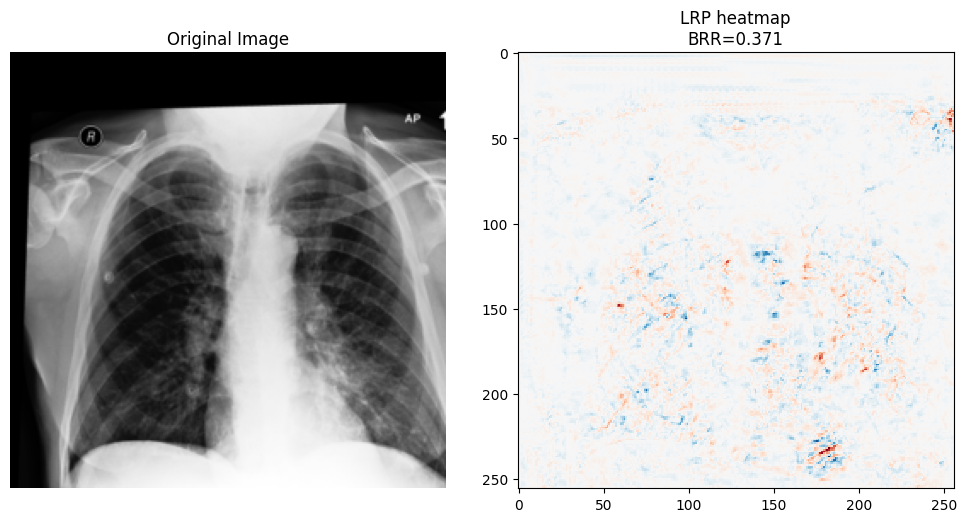

Computing BRR (LRP-Flex):  60%|██████    | 6/10 [00:07<00:04,  1.16s/it]

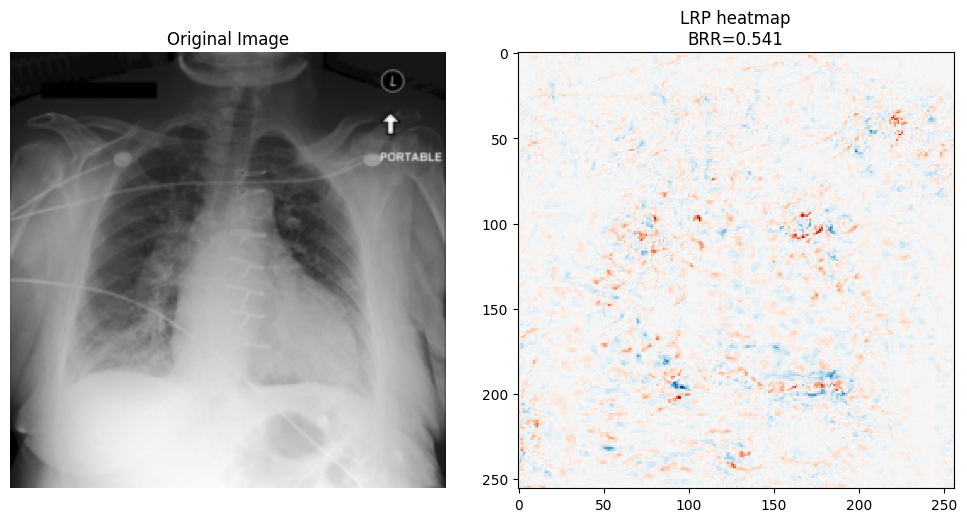

Computing BRR (LRP-Flex):  70%|███████   | 7/10 [00:09<00:04,  1.44s/it]

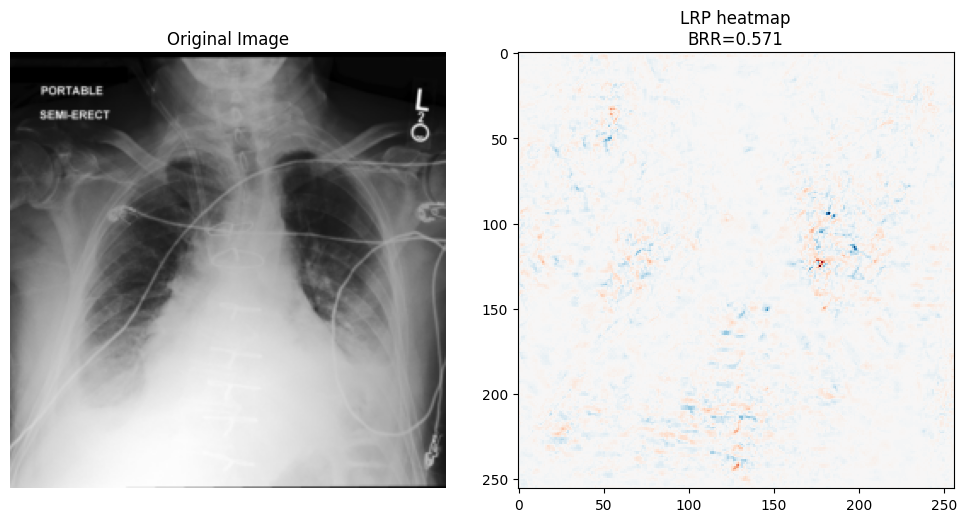

Computing BRR (LRP-Flex):  80%|████████  | 8/10 [00:09<00:02,  1.25s/it]

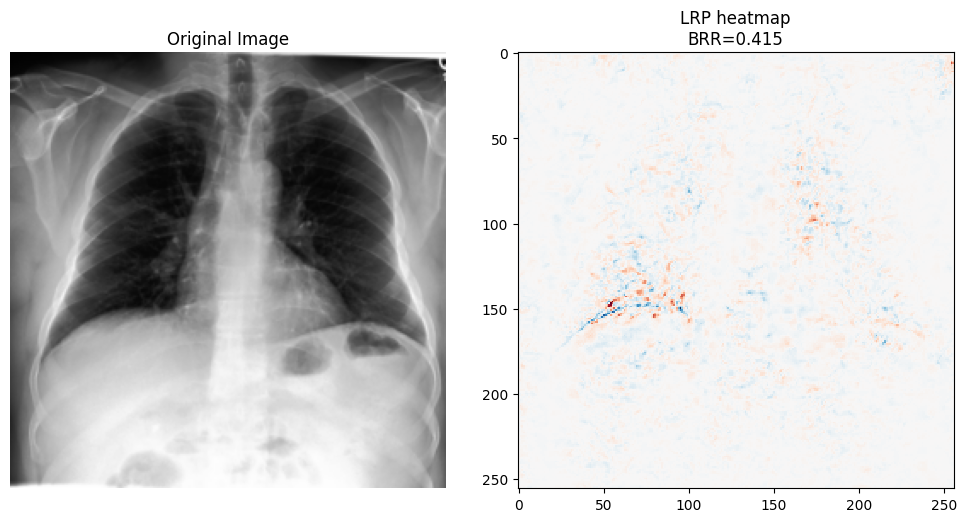

Computing BRR (LRP-Flex):  90%|█████████ | 9/10 [00:10<00:01,  1.02s/it]

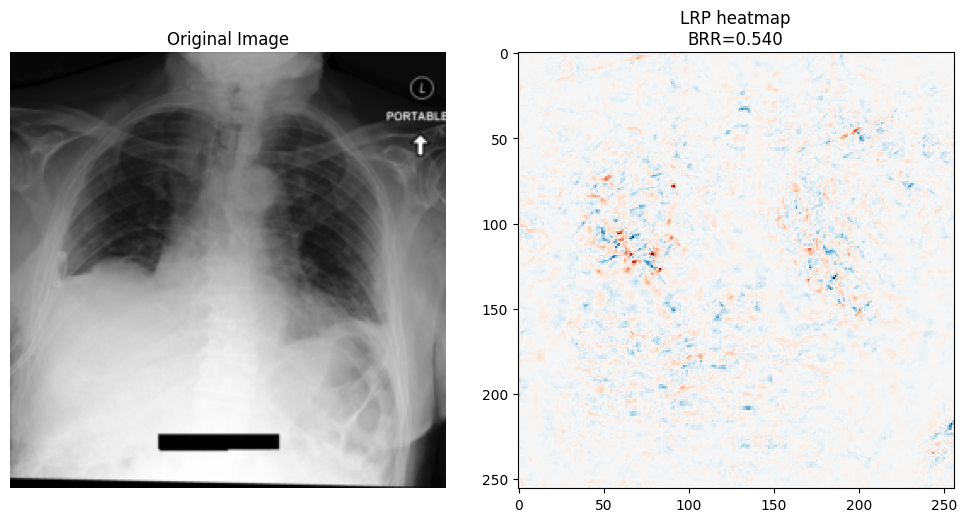

Computing BRR (LRP-Flex): 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


In [24]:
bbr_df_erm_vz=LRPFlex(df_10, densenet_w_ERM, ex_class=0, show=True)

In [18]:
#eval over 1000 CXR
bbr_df_ERM=LRPFlex(df_test_sample, densenet_w_ERM, ex_class=0, show=False)
bbr_df_ERM

Using custom model. Ensure that ReLU layers are not re-utilized inside the model and avoid in-place operations
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]


Computing BRR (LRP-Flex): 100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


dicom_id       BRR  total_relevance
0    0c2c882e-cc89d61c-81dfe6e1-d74c21cb-9c5bbe4b  0.339001         3.034484
1    1df646ba-6a19b819-1d9a5cc3-f662d3f4-1f8c3151  0.440716         3.345594
2    56c0bd85-a8156432-5ef7b12f-c610e5ce-564e3262  0.494298         2.553801
3    7e6619ef-57f3c554-67996673-3e576c6a-2b6eb2b0  0.521802         2.771838
4    453df804-1e4ed7eb-42d68618-7f960573-59ce61c9  0.481020         2.620261
..                                            ...       ...              ...
995  07ce19d0-7c7d6b45-7946f2bb-a9aa3b85-523dde45  0.275809         3.769209
996  50049850-67f37773-8126a761-dc9323df-8acd0dcb  0.445418         3.510179
997  4971ef10-2281563a-b6e17ae2-ca942f9b-1f182d7a  0.415204         2.487063
998  2ad57e0c-78832993-71e9a525-ca36b2fd-f699d3f6  0.455910         3.217285
999  82466d02-64c5db1b-27ae567c-26a90441-4646d106  0.449053         3.099049

[1000 rows x 3 columns]

In [19]:
bbr_df_ERM.describe()

BRR  total_relevance
count  1000.000000      1000.000000
mean      0.448034         3.286579
std       0.080000         0.687494
min       0.156231         1.433691
25%       0.394344         2.846704
50%       0.449598         3.219797
75%       0.502117         3.669297
max       0.733644         8.189301

In [ ]:
#------------ISNetDANN

Using custom model. Ensure that ReLU layers are not re-utilized inside the model and avoid in-place operations
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]


Computing BRR (LRP-Flex):   0%|          | 0/10 [00:00<?, ?it/s]

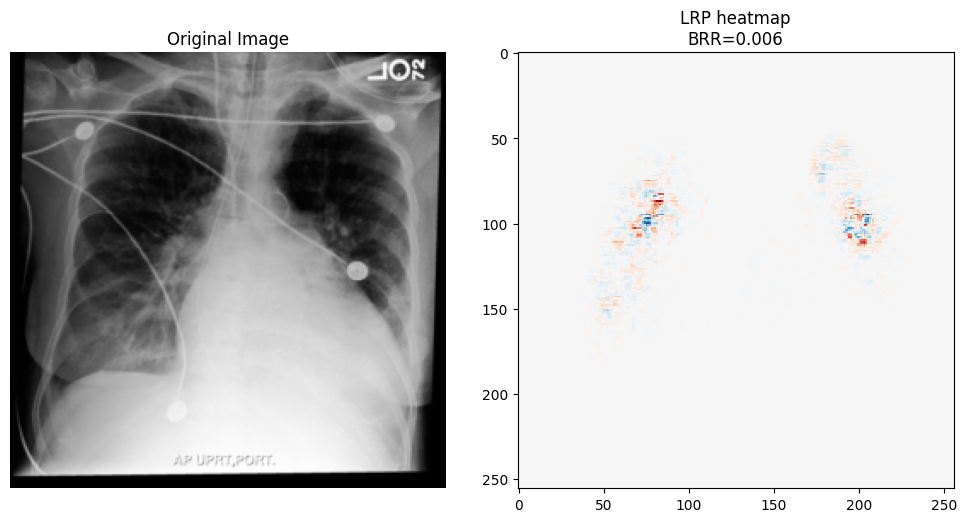

Computing BRR (LRP-Flex):  10%|█         | 1/10 [00:00<00:06,  1.37it/s]

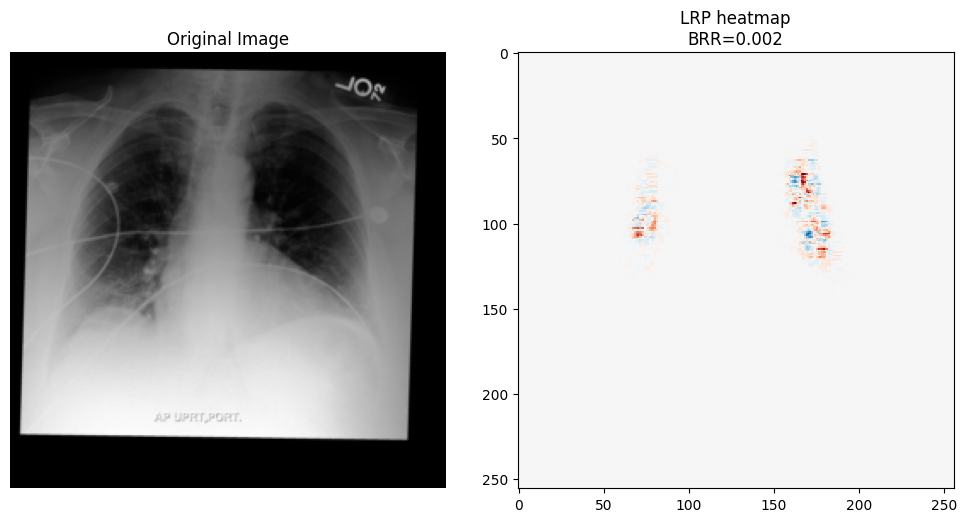

Computing BRR (LRP-Flex):  20%|██        | 2/10 [00:01<00:08,  1.02s/it]

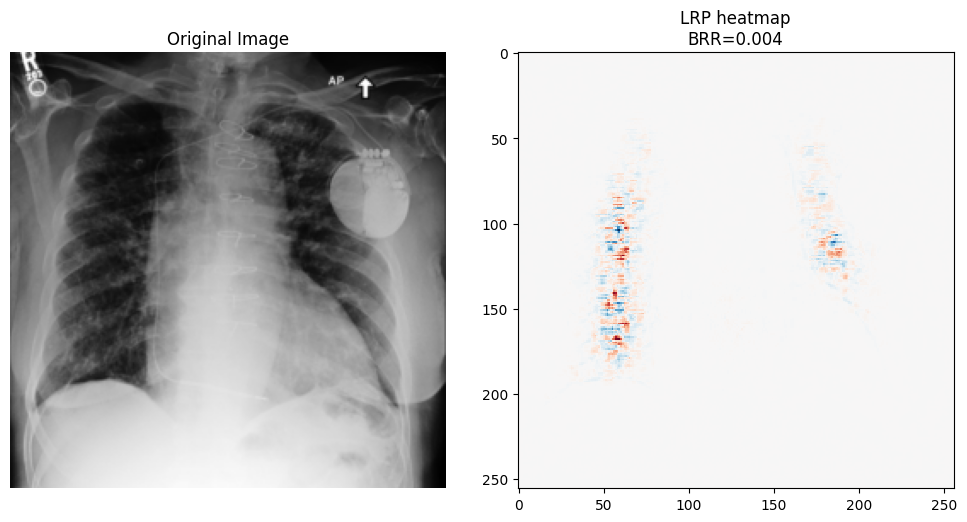

Computing BRR (LRP-Flex):  30%|███       | 3/10 [00:04<00:13,  1.94s/it]

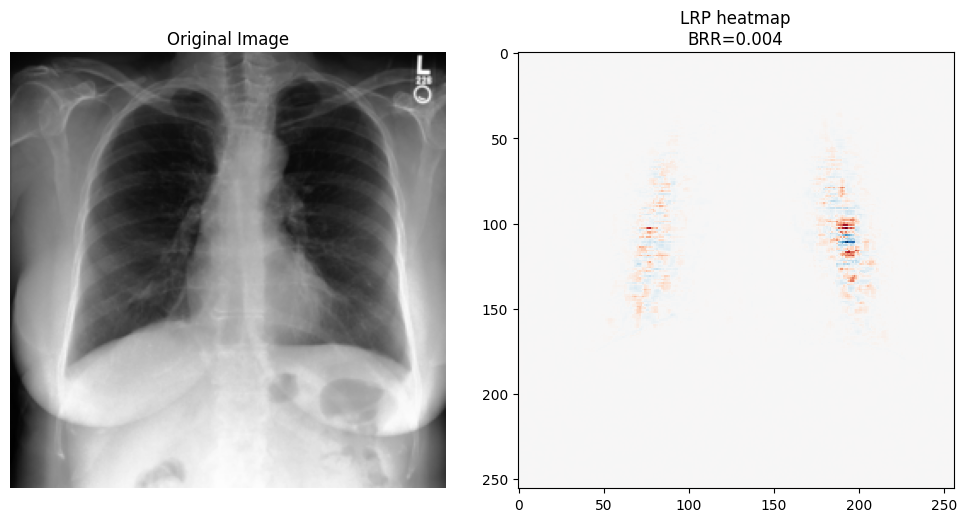

Computing BRR (LRP-Flex):  40%|████      | 4/10 [00:05<00:08,  1.37s/it]

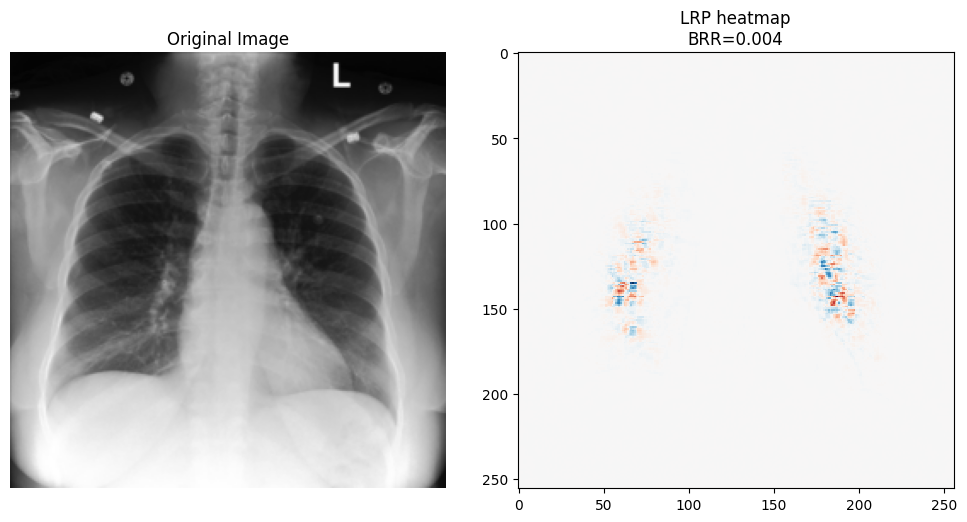

Computing BRR (LRP-Flex):  50%|█████     | 5/10 [00:06<00:05,  1.13s/it]

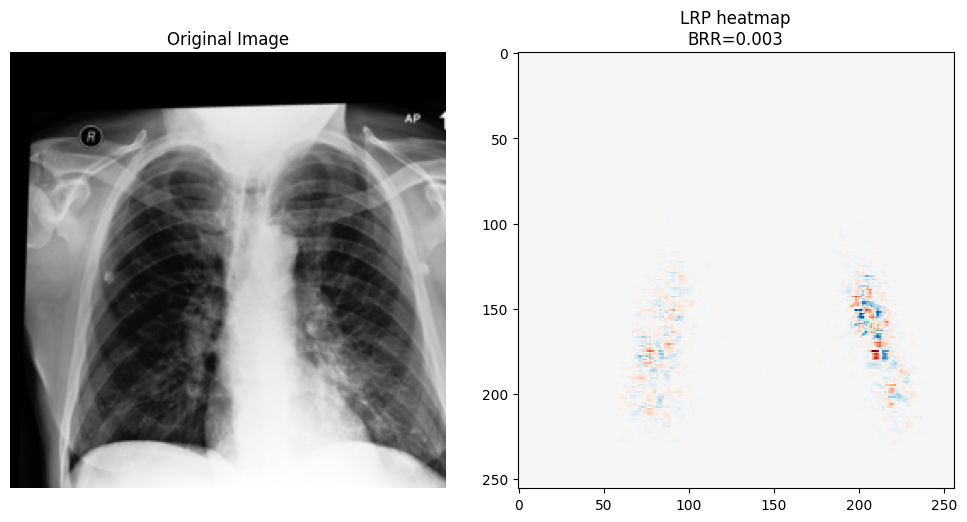

Computing BRR (LRP-Flex):  60%|██████    | 6/10 [00:07<00:05,  1.26s/it]

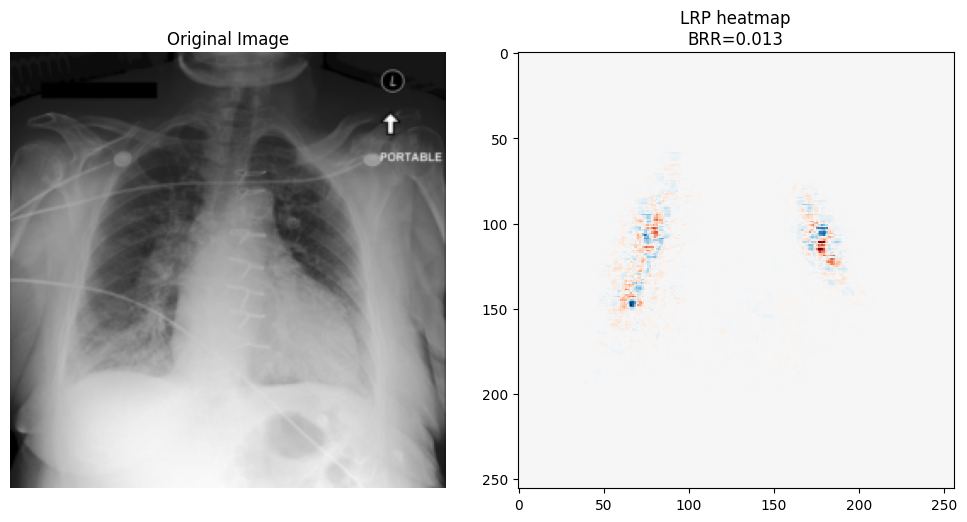

Computing BRR (LRP-Flex):  70%|███████   | 7/10 [00:09<00:04,  1.43s/it]

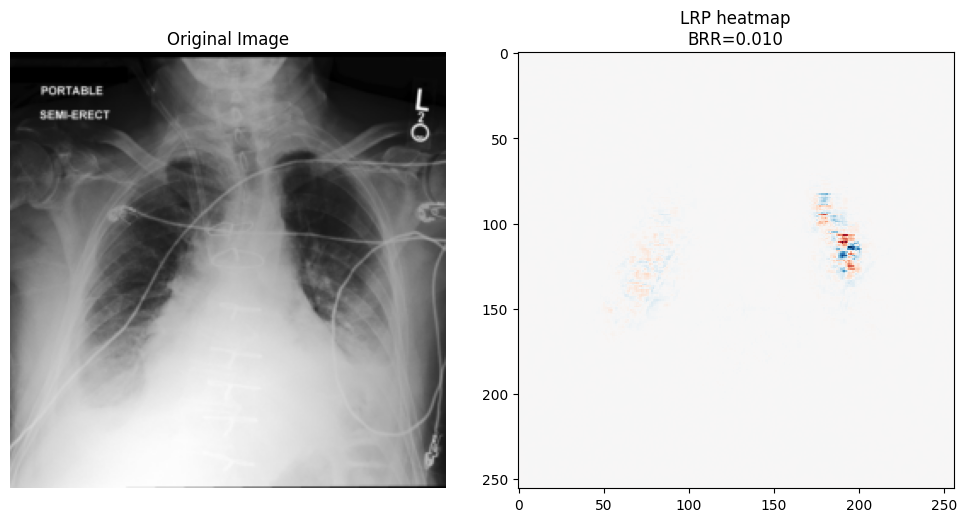

Computing BRR (LRP-Flex):  80%|████████  | 8/10 [00:12<00:03,  1.92s/it]

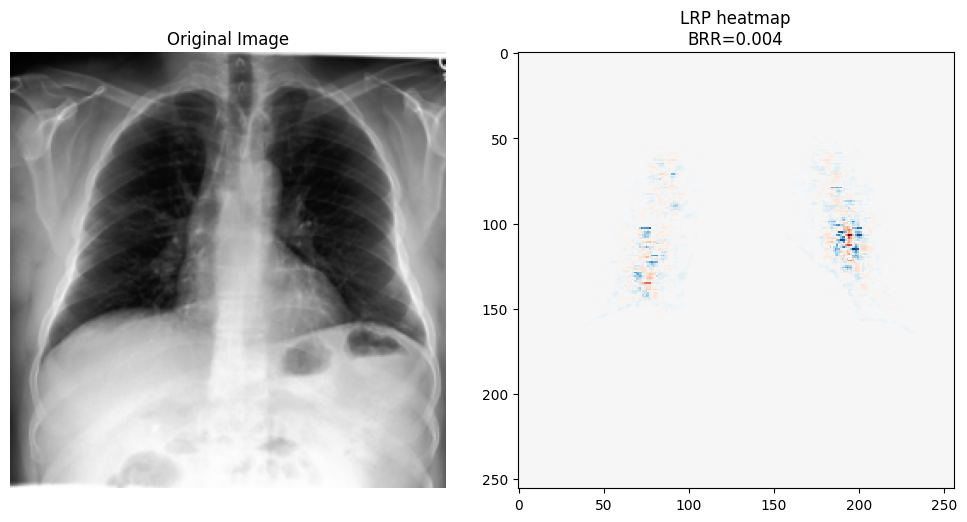

Computing BRR (LRP-Flex):  90%|█████████ | 9/10 [00:13<00:01,  1.56s/it]

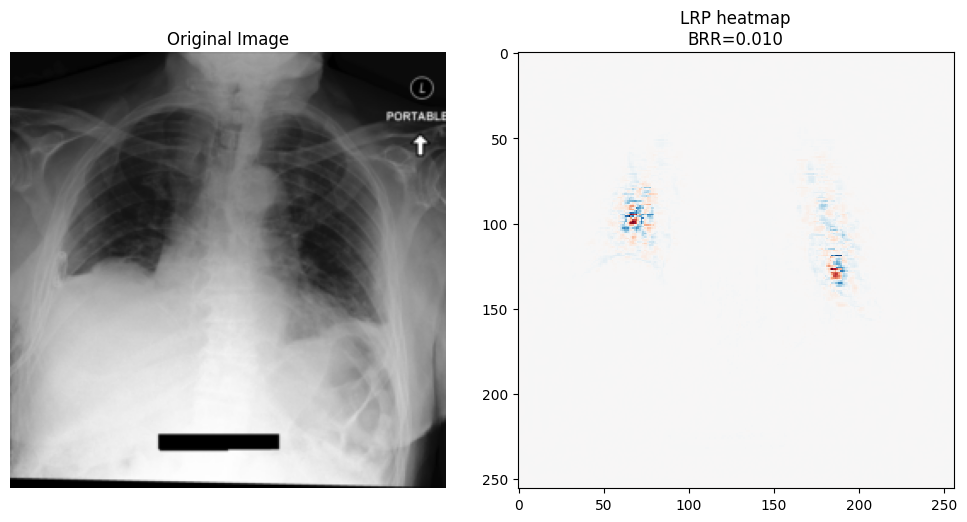

Computing BRR (LRP-Flex): 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


In [27]:
bbr_df_isnerdann_vz=LRPFlex(df_10, densenet_w_ISNetDANN, ex_class=0, show=True)

In [20]:
#eval over 1000 CXR
bbr_df_ISNetDANN=LRPFlex(df_test_sample, densenet_w_ISNetDANN, ex_class=0, show=False)
bbr_df_ISNetDANN

Using custom model. Ensure that ReLU layers are not re-utilized inside the model and avoid in-place operations
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]


Computing BRR (LRP-Flex): 100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]


dicom_id       BRR  total_relevance
0    0c2c882e-cc89d61c-81dfe6e1-d74c21cb-9c5bbe4b  0.003779         5.843256
1    1df646ba-6a19b819-1d9a5cc3-f662d3f4-1f8c3151  0.001607         4.983348
2    56c0bd85-a8156432-5ef7b12f-c610e5ce-564e3262  0.006314         3.897888
3    7e6619ef-57f3c554-67996673-3e576c6a-2b6eb2b0  0.005546         5.860597
4    453df804-1e4ed7eb-42d68618-7f960573-59ce61c9  0.003568         5.529535
..                                            ...       ...              ...
995  07ce19d0-7c7d6b45-7946f2bb-a9aa3b85-523dde45  0.008975         5.613595
996  50049850-67f37773-8126a761-dc9323df-8acd0dcb  0.003314         7.303971
997  4971ef10-2281563a-b6e17ae2-ca942f9b-1f182d7a  0.009324         2.111068
998  2ad57e0c-78832993-71e9a525-ca36b2fd-f699d3f6  0.004187         6.620170
999  82466d02-64c5db1b-27ae567c-26a90441-4646d106  0.002178         4.483731

[1000 rows x 3 columns]

In [21]:
bbr_df_ISNetDANN.describe()

BRR  total_relevance
count  1000.000000      1000.000000
mean      0.010682         4.616710
std       0.043059         1.576078
min       0.000765         0.227995
25%       0.003433         3.607961
50%       0.004701         4.910068
75%       0.008017         5.726930
max       0.719716        12.039202

In [ ]:
#=============LRP Flex implementation===========

In [ ]:
#===============comparisson===============

In [22]:
#95% CI boostrap
def bootstrap_ci(values, n_bootstrap=1000, alpha=0.05):
    values = np.asarray(values, dtype=float)
    boot_means = []

    for _ in range(n_bootstrap):# Bootstrap procedure: resample the data with replacement n_bootstrap times
        sample = np.random.choice(values, size=len(values), replace=True) # Draw a bootstrap sample of the same size as the original data
        boot_means.append(sample.mean()) # Compute the statistic of interest (mean) for the bootstrap sample

    # Compute the lower bound of the (1 - alpha) confidence interval using the percentile method
    ci_low = np.percentile(boot_means, 100 * alpha / 2) 
    ci_high = np.percentile(boot_means, 100 * (1 - alpha / 2))

    return ci_low, ci_high

In [ ]:
#-------------ERM

In [23]:
metrics = [
    'BRR'
]

rows = []

for metric in metrics:

    values = bbr_df_ERM[metric]

    mean = values.mean()
    std = values.std(ddof=1)

    ci_low, ci_high = bootstrap_ci(values)

    rows.append({
        'model': 'ERM',
        'task': 'No finding',
        'attr': 'sex',
        'metric': metric,
        'mean': mean,
        'std': std,
        'ci95_low': ci_low,
        'ci95_high': ci_high,
        'ci95_range': ci_high - ci_low
    })

df_bbr_df_ERM = pd.DataFrame(rows)
df_bbr_df_ERM


model        task attr metric      mean   std  ci95_low  ci95_high  \
0   ERM  No finding  sex    BRR  0.448034  0.08   0.44286   0.452885   

   ci95_range  
0    0.010025

In [ ]:
#-------------ISNetDANN

In [24]:
metrics = [
    'BRR'
]

rows = []

for metric in metrics:

    values = bbr_df_ISNetDANN[metric]

    mean = values.mean()
    std = values.std(ddof=1)

    ci_low, ci_high = bootstrap_ci(values)

    rows.append({
        'model': 'ISNetDANN',
        'task': 'No finding',
        'attr': 'sex',
        'metric': metric,
        'mean': mean,
        'std': std,
        'ci95_low': ci_low,
        'ci95_high': ci_high,
        'ci95_range': ci_high - ci_low
    })

df_bbr_df_ISNetDANN = pd.DataFrame(rows)
df_bbr_df_ISNetDANN


model        task attr metric      mean       std  ci95_low  ci95_high  \
0  ISNetDANN  No finding  sex    BRR  0.010682  0.043059   0.00829   0.013338   

   ci95_range  
0    0.005049

In [25]:
df_BRR_comparison = pd.concat([df_bbr_df_ERM, df_bbr_df_ISNetDANN], axis=0)
df_BRR_comparison 

model        task attr metric      mean       std  ci95_low  ci95_high  \
0        ERM  No finding  sex    BRR  0.448034  0.080000   0.44286   0.452885   
0  ISNetDANN  No finding  sex    BRR  0.010682  0.043059   0.00829   0.013338   

   ci95_range  
0    0.010025  
0    0.005049

In [26]:
BRR_ERM=df_BRR_comparison.iloc[0, 4]
BRR_ISNetDANN=df_BRR_comparison .iloc[1, 4]
print("BRR ERM:", BRR_ERM)
print("BRR ISNetDANN:", BRR_ISNetDANN)


mean_diff=BRR_ERM-BRR_ISNetDANN
print("mean_diff:", mean_diff)

per_mean_diff=((BRR_ERM-BRR_ISNetDANN)/BRR_ERM)*100
print("% mean_diff:", per_mean_diff)

BRR ERM: 0.44803355198496814
BRR ISNetDANN: 0.010681877758728003
mean_diff: 0.4373516742262401
% mean_diff: 97.61583084315828


In [35]:
from scipy import stats

In [41]:
brr_isnet=bbr_df_ISNetDANN['BRR']
brr_erm=bbr_df_ERM['BRR']

In [46]:
t_stat, p_value = stats.ttest_ind(
    brr_isnet,
    brr_erm,
    equal_var=False  #Welch
)

t_stat, p_value


(-152.22908053269944, 0.0)

In [ ]:
#Esto no significa que el p-valor sea exactamente cero.
#Significa que es tan pequeño que no puede representarse con precisión numérica (menor que ~1e-308).

In [ ]:
bbr_df_ISNetDANN.insert(0, "model", "ISNetDANN")
bbr_df_ERM.insert(0, "model", "ERM")
df_BRR_comparison_inde = pd.concat([bbr_df_ISNetDANN, bbr_df_ERM], axis=0)

In [38]:
df_BRR_comparison_inde 

model                                      dicom_id       BRR  \
0          ERM  0c2c882e-cc89d61c-81dfe6e1-d74c21cb-9c5bbe4b  0.339001   
1          ERM  1df646ba-6a19b819-1d9a5cc3-f662d3f4-1f8c3151  0.440716   
2          ERM  56c0bd85-a8156432-5ef7b12f-c610e5ce-564e3262  0.494298   
3          ERM  7e6619ef-57f3c554-67996673-3e576c6a-2b6eb2b0  0.521802   
4          ERM  453df804-1e4ed7eb-42d68618-7f960573-59ce61c9  0.481020   
..         ...                                           ...       ...   
995  ISNetDANN  07ce19d0-7c7d6b45-7946f2bb-a9aa3b85-523dde45  0.008975   
996  ISNetDANN  50049850-67f37773-8126a761-dc9323df-8acd0dcb  0.003314   
997  ISNetDANN  4971ef10-2281563a-b6e17ae2-ca942f9b-1f182d7a  0.009324   
998  ISNetDANN  2ad57e0c-78832993-71e9a525-ca36b2fd-f699d3f6  0.004187   
999  ISNetDANN  82466d02-64c5db1b-27ae567c-26a90441-4646d106  0.002178   

     total_relevance  
0           3.034484  
1           3.345594  
2           2.553801  
3           2.771838  
4           2.620261  
..               ...  
995         5.613595  
996         7.303971  
997         2.111068  
998         6.620170  
999         4.483731  

[2000 rows x 4 columns]

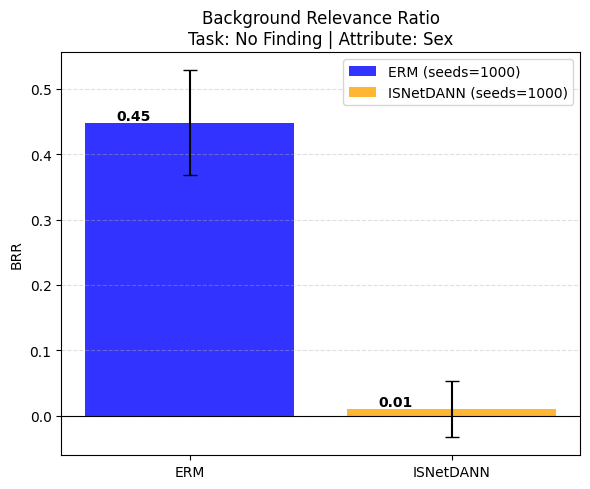

In [51]:
import numpy as np
import matplotlib.pyplot as plt

colors = {"ERM": "blue", "ISNetDANN": "orange"}
model_order = ["ERM", "ISNetDANN"]


df = df_BRR_comparison_inde.copy()


df_stats = (
    df.groupby("model")["BRR"]
    .agg(BRR_mean="mean", BRR_std="std", seed_number="count")
    .reindex(model_order)
    .reset_index()
)


fig, ax = plt.subplots(figsize=(6, 5))


bars = ax.bar(
    df_stats["model"],
    df_stats["BRR_mean"],
    yerr=df_stats["BRR_std"],
    capsize=5,
    color=[colors[m] for m in df_stats["model"]],
    alpha=0.8
)

for bar, mean, std in zip(bars, df_stats["BRR_mean"], df_stats["BRR_std"]):
    ax.text(
        bar.get_x() + bar.get_width() * 0.15, 
        mean,                            
        f"{mean:.2f}",
        ha="left",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

"""
for i, model in enumerate(model_order):
    values = df[df["model"] == model]["fair_gap"]

    jitter = np.random.normal(0, 0.04, size=len(values))

    ax.scatter(
        np.full(len(values), i) + jitter,
        values,
        color="black",
        zorder=10,
        alpha=0.7
    )
"""

legend_labels = [
    f"{row.model} (seeds={row.seed_number})"
    for row in df_stats.itertuples()
]
ax.legend(bars, legend_labels, loc="upper right")


ax.set_ylabel("BRR")
ax.set_title("Background Relevance Ratio\nTask: No Finding | Attribute: Sex")
ax.axhline(0, color="black", linewidth=0.8)
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
#===============comparisson===============